# Appalachian Station Situations Analysis
This notebook loads the dataset, explores key metrics, and reproduces charts.

In [17]:
!pip install cartopy

In [18]:
!pip install seaborn

In [19]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Noto Sans CJK SC', 'Noto Sans CJK TC', 'Noto Sans CJK JP', 'Noto Sans CJK KR']
plt.rcParams['axes.unicode_minus'] = False
CSV_PATH = 'appalachian_BH_stations_1.5yr_plus.csv'
df = pd.read_csv(CSV_PATH)
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')
for col in ['latitude','longitude','elevation_m','duration_years']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['start_year'] = df['start_date'].dt.year
df.head()


,network,station,latitude,longitude,elevation_m,start_date,end_date,duration_years,start_year
0,PN,PPHHS,37.972000,-87.486000,122.2,1999-01-01,2026-01-09,27.025194,1999
1,PN,PPMUN,40.201000,-85.387001,280.0,1999-01-01,2026-01-09,27.025194,1999
2,PN,PNNAF,38.333000,-85.931000,22.9,1999-01-01,2026-01-09,27.025194,1999
3,PN,PURD,40.438000,-86.946198,207.0,1999-01-10,2026-01-09,27.000553,1999
4,SS,NCAT,36.078957,-79.771179,243.0,2009-02-03,2026-01-09,16.933476,2009


In [20]:
summary = {
    'total_stations': int(df.shape[0]),
    'networks_count': int(df['network'].nunique()),
    'stations_count_unique': int(df['station'].nunique()),
    'duration_years': {
        'min': float(np.nanmin(df['duration_years'])),
        'max': float(np.nanmax(df['duration_years'])),
        'mean': float(np.nanmean(df['duration_years'])),
        'median': float(np.nanmedian(df['duration_years'])),
    },
    'elevation_m': {
        'min': float(np.nanmin(df['elevation_m'])),
        'max': float(np.nanmax(df['elevation_m'])),
        'mean': float(np.nanmean(df['elevation_m'])),
        'median': float(np.nanmedian(df['elevation_m'])),
    },
}
summary


{'total_stations': 447,
 'networks_count': 18,
 'stations_count_unique': 394,
 'duration_years': {'min': 1.5294509088143584,
  'max': 27.025193663560696,
  'mean': 2.941584751669499,
  'median': 2.002414600603341},
 'elevation_m': {'min': -3.0,
  'max': 1180.0,
  'mean': 234.31946308724832,
  'median': 199.0}}

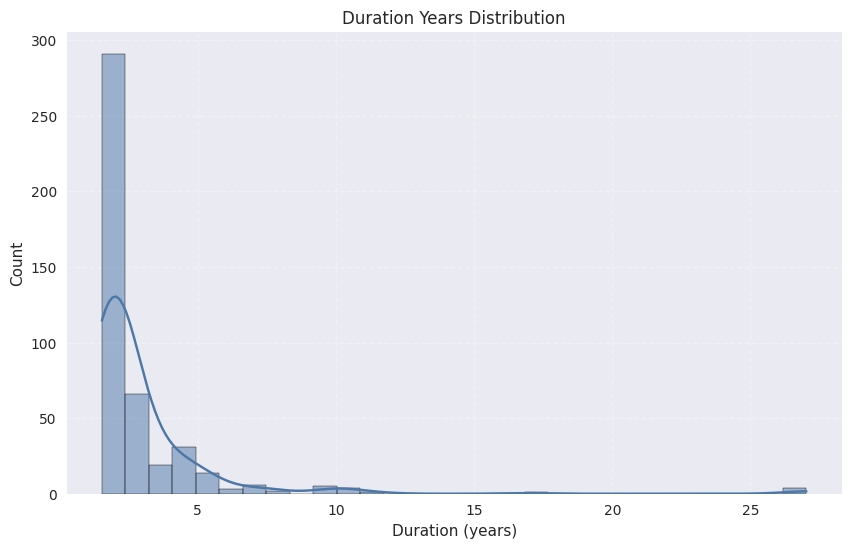

In [21]:
# Duration histogram
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(df['duration_years'].dropna(), bins=30, kde=True, ax=ax, color='#4C78A8')
ax.set_title('Duration Years Distribution')
ax.set_xlabel('Duration (years)')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.3, linestyle='--')
plt.show()


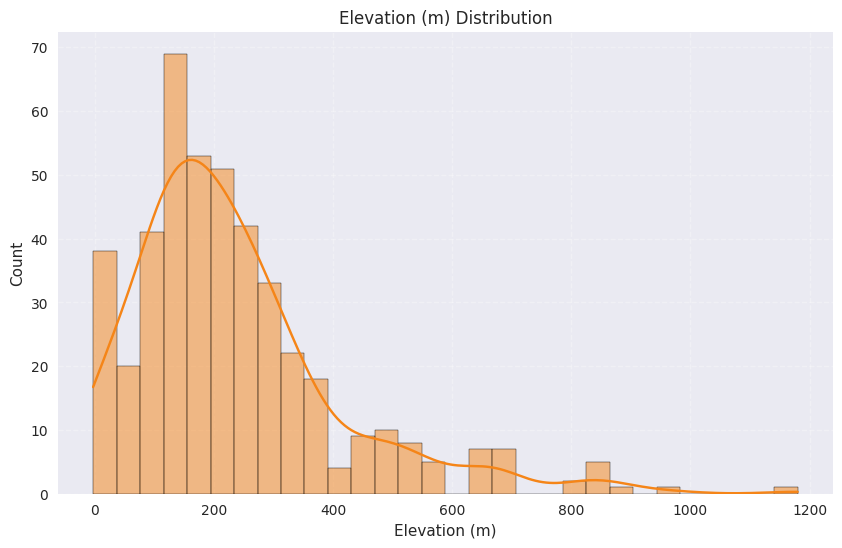

In [22]:
# Elevation histogram
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(df['elevation_m'].dropna(), bins=30, kde=True, ax=ax, color='#F58518')
ax.set_title('Elevation (m) Distribution')
ax.set_xlabel('Elevation (m)')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.3, linestyle='--')
plt.show()


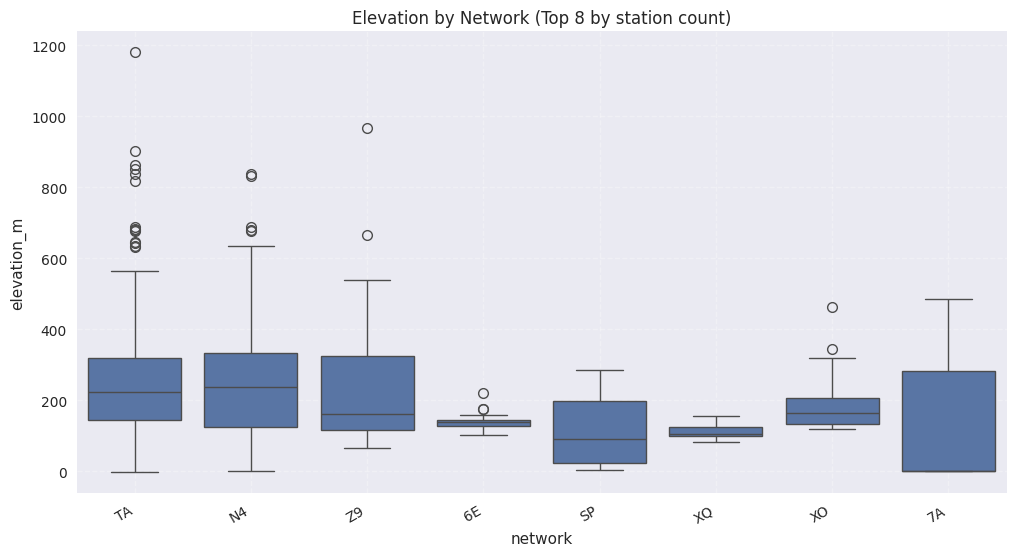

In [23]:
# Elevation boxplot by network (Top 8)
net_summary = df.groupby('network').agg(stations=('station','nunique')).reset_index().sort_values('stations', ascending=False)
top_networks = net_summary.head(8)['network'].tolist()
df_topnet = df[df['network'].isin(top_networks)]
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=df_topnet, x='network', y='elevation_m', ax=ax)
ax.set_title('Elevation by Network (Top 8 by station count)')
ax.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=30, ha='right')
plt.show()


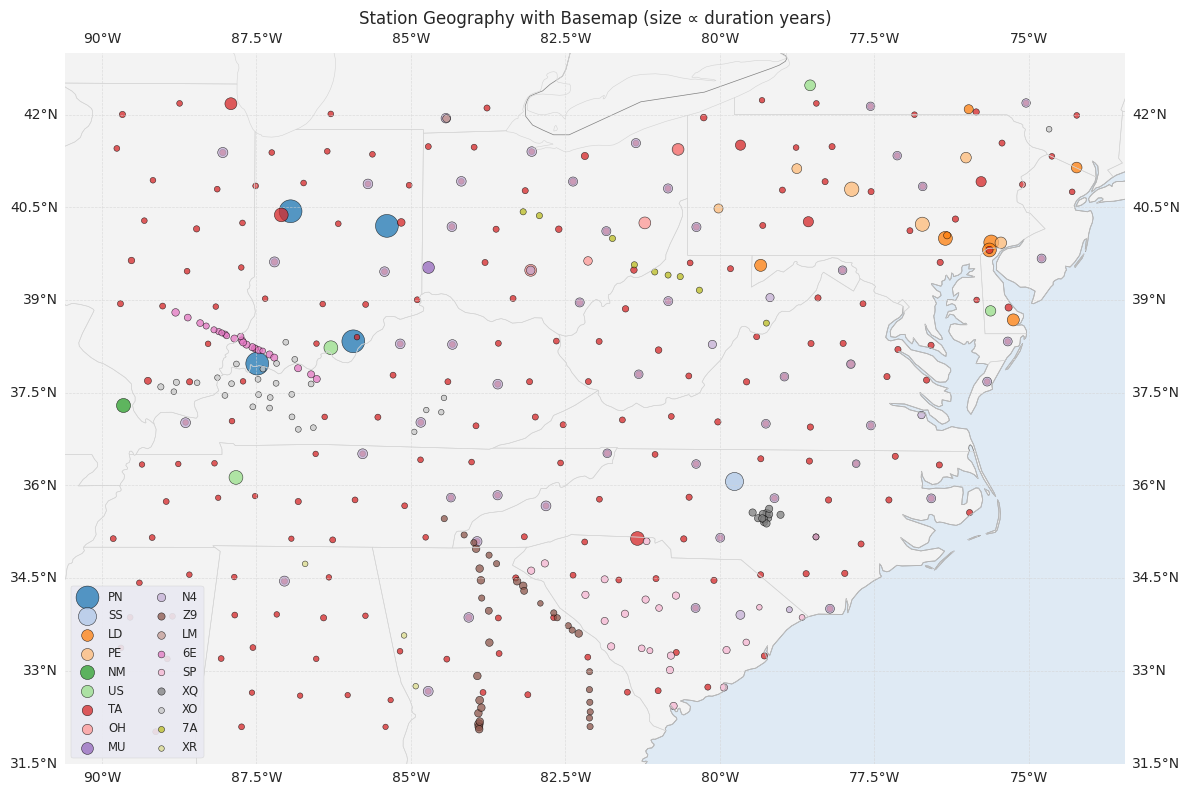

In [24]:
# 4) Geographic scatter with basemap (lon vs lat), point size by duration
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Compute extent with margins
min_lon, max_lon = df['longitude'].min(), df['longitude'].max()
min_lat, max_lat = df['latitude'].min(), df['latitude'].max()
lon_margin = (max_lon - min_lon) * 0.05
lat_margin = (max_lat - min_lat) * 0.05
extent = [min_lon - lon_margin, max_lon + lon_margin, min_lat - lat_margin, max_lat + lat_margin]

fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add basemap features
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#f3f3f3')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#dfeaf4')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6, edgecolor='gray')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.5, edgecolor='gray')
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.4, edgecolor='lightgray')
ax.gridlines(draw_labels=True, linewidth=0.5, color='lightgray', alpha=0.7, linestyle='--')

networks = df['network'].astype(str).unique()
palette = sns.color_palette('tab20', n_colors=len(networks))
net_color = {net: palette[i % len(palette)] for i, net in enumerate(networks)}

for net in networks:
    sub = df[df['network'] == net]
    ax.scatter(sub['longitude'], sub['latitude'], s=np.clip(sub['duration_years']*10, 10, 300),
               c=[net_color[net]], alpha=0.75, label=net, edgecolors='black', linewidths=0.4,
               transform=ccrs.PlateCarree())

ax.set_title('Station Geography with Basemap (size ∝ duration years)')
legend = ax.legend(loc='lower left', fontsize='small', ncol=2, frameon=True)
legend.get_frame().set_alpha(0.9)

fig.tight_layout()
fig.savefig('geo_scatter_basemap.png', dpi=300)
plt.show()


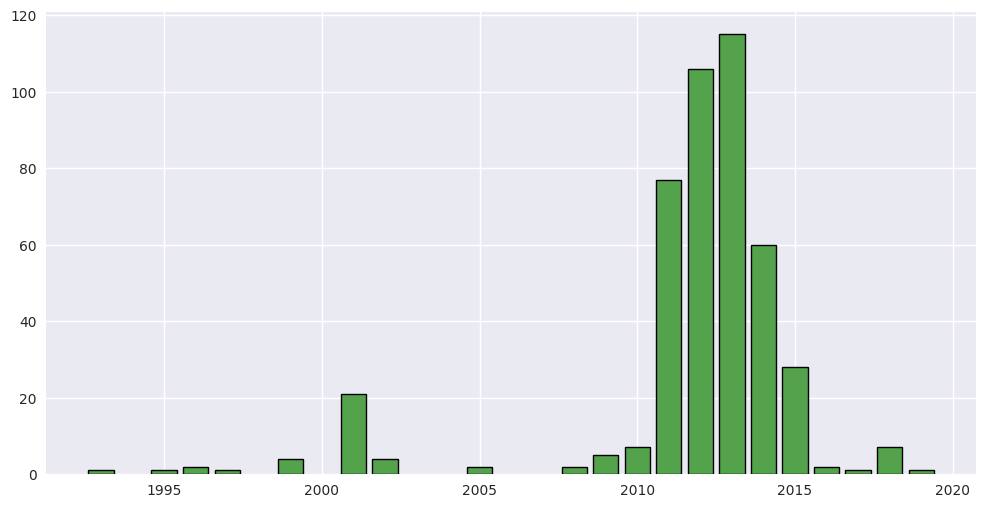

In [25]:
# Start year counts
year_counts = df['start_year'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(year_counts.index, year_counts.values, color='#54A24B', edgecolor='black', linewidth=1.0)
plt.show()


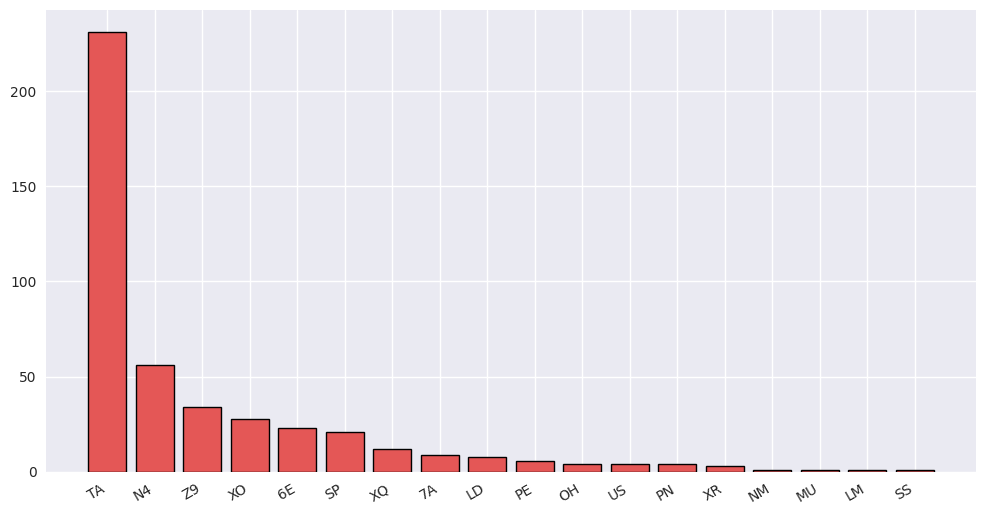

In [26]:
# Network station counts
net_summary = df.groupby('network').agg(stations=('station','nunique')).reset_index().sort_values('stations', ascending=False)
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(net_summary['network'], net_summary['stations'], color='#E45756', edgecolor='black', linewidth=1.0)
plt.xticks(rotation=30, ha='right')
plt.show()
